In [130]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,AveragePooling2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Add,Input,Activation

In [119]:
!pip install opencv-python

# Importing data and making train-test splits

In [132]:
import glob
import librosa
import numpy as np
import cv2 
Mild_Demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
Moderate_Demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
Non_Demented= glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
Very_Mild_Demented= glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []
labels = []

image_size=(128,128)

for i in Mild_Demented:   
    image = cv2.imread(i)
    image = cv2.resize(image, image_size)
    
    data.append(image)
    labels.append(0)
    
for i in Moderate_Demented:   
    image = cv2.imread(i)
    image = cv2.resize(image, image_size)
    
    data.append(image)
    labels.append(1)
    
for i in Non_Demented:   
    image = cv2.imread(i)
    image = cv2.resize(image, image_size)
    
    data.append(image)
    labels.append(2)
    
for i in Very_Mild_Demented:   
    image = cv2.imread(i)
    image = cv2.resize(image, image_size)
    
    data.append(image)
    labels.append(3)

X=np.array(data)
y=np.array(labels)
print(X.shape)
print(y.shape)

(6400, 128, 128, 3)
(6400,)


In [133]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [134]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4096, 128, 128, 3)
(1024, 128, 128, 3)
(1280, 128, 128, 3)
(4096,)
(1024,)
(1280,)


In [135]:
# Transform targets to keras compatible format
#y_train = np_utils.to_categorical(y_train, num_classes=4)
#y_val = np_utils.to_categorical(y_val, num_classes=4)
#y_test = np_utils.to_categorical(y_test, num_classes=4)

#Normalize data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
 
X_train = X_train / 255.0
X_val = X_val/ 255.0
X_test = X_test/ 255.0

In [143]:
y_train

array([0, 3, 0, ..., 3, 2, 0])

# Building the ResNet Architecture

In [136]:
#Define identity block(For solid residue lines)

def id_block(x,filter_number):
    

    #Saving the input for add()
    res_x=x

    #Layer 1
    x = Conv2D(filter_number, (3, 3), padding ='same', activation='relu')(x)

    #Layer 2
    x = Conv2D(filter_number, (3, 3),padding='same')(x)

    #Add residue
    x = Add()([x, res_x])
    x = Activation('relu')(x)

    return x

In [137]:
#Define convolution block(For dotted residue lines- 1x1 conv added before add())

def conv_block(x,filter_number):
    
    #Saving the input for add()
    res_x=x

    #Layer 1
    x = Conv2D(filter_number, (3, 3), strides=(2,2), padding ='same', activation='relu')(x) #strides added

    #Layer 2
    x = Conv2D(filter_number, (3, 3),padding='same')(x)

    #residue passed through conv 1x1 before add()
    res_x= Conv2D(filter_number, (1,1), strides = (2,2))(res_x)

    #Add residue
    x = Add()([x, res_x])
    x = Activation('relu')(x)

    return x

In [144]:
def ResNet34(image_shape, class_number):
    # Define the input tensor
    inputs = Input(shape=image_shape)

    #Step_1 Initial conv layer with MaxPool
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #Step_2 Define block bundle sizes
    block_size = [3,4,6,3]
    filter_number= 64

    #Step_3 Block in loops

    for i in range(4):

        if i==0:
            #No conv block in this bundle
            for j in range(block_size[i]):
                x=id_block(x,filter_number)
        else: #The first block is conv block, the rest in identity blocks and filter number increases 2x in each iteration
            filter_number = filter_number*2
            x = conv_block(x, filter_number)

            for j in range(block_size[i] - 1):
                x = id_block(x, filter_number)

    #Step_4 Add dense layers

    # Average Pooling
    x = AveragePooling2D((2,2),padding='same')(x)

    # Flatten the feature maps
    x = Flatten()(x)

    # Add a fully connected Dense layer with 512 units and 'relu' activation
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)

    # Add the output layer with the desired number of units and activation function
    outputs = Dense(class_number, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name="ResNet34")

    return model

# Training and Evaluating

In [145]:
image_shape=(128,128,3)
class_number=4

model=ResNet34(image_shape, class_number)

In [146]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_174 (Conv2D)            (None, 64, 64, 64)   9472        ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 32, 32, 64)  0           ['conv2d_174[0][0]']             
                                                                                                  
 conv2d_175 (Conv2D)            (None, 32, 32, 64)   36928       ['max_pooling2d_7[0][0]'] 

In [148]:
#Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the learning rate reduction callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.1,            
    patience=5,           
    min_lr=1e-6            
)
# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the learning rate reduction callback
history = model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=10, batch_size=32,callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(X_test, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/10
128/128 [==============================] - 464s 4s/step - loss: 1.0727 - accuracy: 0.5059 - val_loss: 3.9605 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 484s 4s/step - loss: 0.9465 - accuracy: 0.5283 - val_loss: 1.9136 - val_accuracy: 0.1592 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 458s 4s/step - loss: 0.9311 - accuracy: 0.5356 - val_loss: 61.0310 - val_accuracy: 0.1348 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 458s 4s/step - loss: 0.9377 - accuracy: 0.5420 - val_loss: 0.8990 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 455s 4s/step - loss: 0.9297 - accuracy: 0.5444 - val_loss: 4.5968 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 453s 4s/step - loss: 0.9116 - accuracy: 0.5522 - val_loss: 1.2647 - val_accuracy: 0.3721 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 454s 4s/s

40/40 [==============================] - 29s 712ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.16      1.00      0.27       201
 Moderate_Demented       0.00      0.00      0.00         6
      Non-Demented       0.00      0.00      0.00       643
Very_Mild_Demented       0.00      0.00      0.00       430

          accuracy                           0.16      1280
         macro avg       0.04      0.25      0.07      1280
      weighted avg       0.02      0.16      0.04      1280



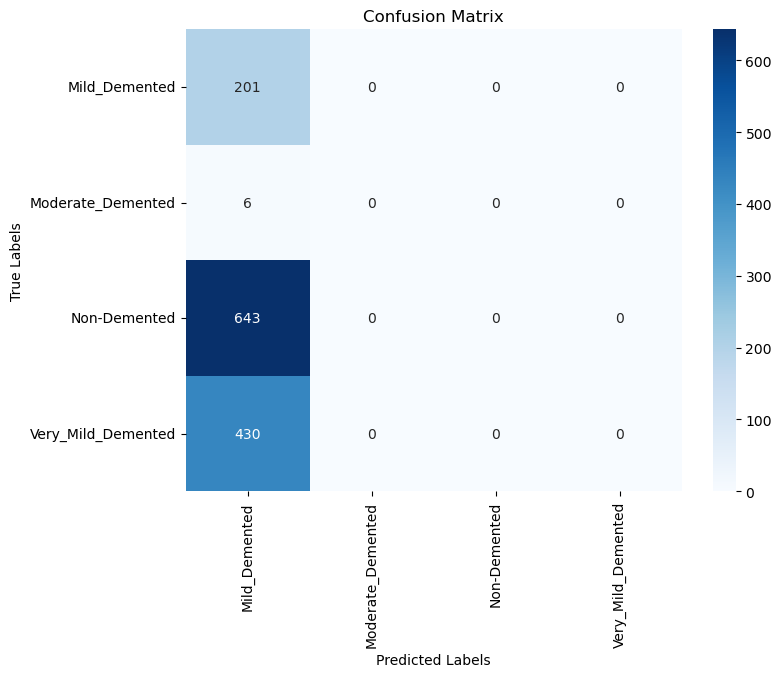

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


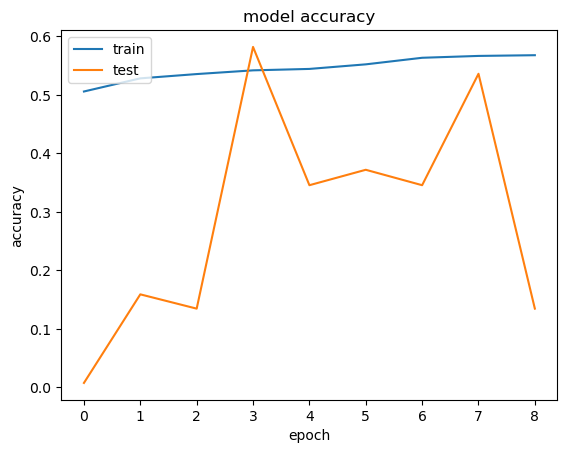

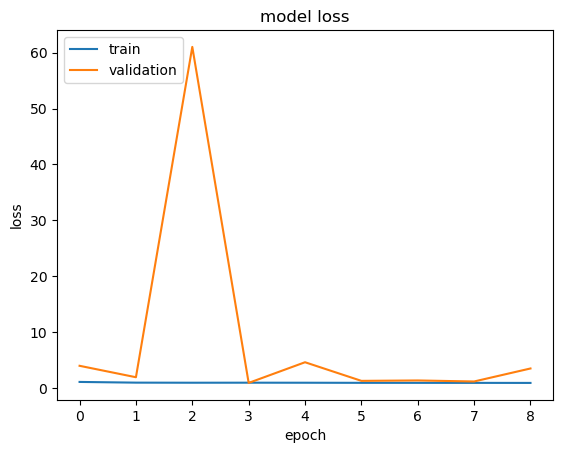

In [150]:
# Make predictions on new images
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = list(['Mild_Demented','Moderate_Demented','Non-Demented','Very_Mild_Demented'])
report = classification_report(y_test, predicted_classes , target_names=class_names)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()